### Flow Predition for Wastewater Treatment Plant

### Data Cleaning and Exploratory Data Analysis



### 1. Data Cleaning

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from datetime import datetime


### Dataset No.1 : Wastewater Treatment Plant Records
- Data of daily flow and precipitation 

In [13]:
#import flow data from the Wastewater Treatment Plant
df_wwtp_flow = pd.read_csv('data/wwtp_flow.csv') #records of daily flow from the treatment plant
df_wwtp_flow['date']=pd.to_datetime(df_wwtp_flow['date'])
df_wwtp_flow.set_index('date',inplace=True)
df_wwtp_flow.drop(columns = ['flow_max','flow_min','precip'],inplace = True) #remove columns no used
df_wwtp_flow.rename({'flow_avg': 'wwtp_flow'}, axis=1, inplace=True)
df_wwtp_flow.head()

,wwtp_flow
date,
2021-05-01,15.808696
2021-05-02,18.125000
2021-05-03,17.750000
2021-05-04,19.079167
2021-05-05,16.915417


### Dataset No.2: Precipitation Data from NYS Mesonet Site
- Hourly precipitation data from Suffern NY

In [14]:
#import precipitation Data
df_precip= pd.read_csv('data/suff.csv')
df_precip.drop(columns = ['station'], inplace = True)
df_precip.rename({'precip_1hr_max [inch]': 'precip', 'time_end':'date'}, axis=1, inplace=True)
df_precip['date'] = df_precip['date'].str.replace('EST', '')
df_precip['date'] = df_precip['date'].str.replace('EDT', '')
df_precip['date']= pd.to_datetime(df_precip['date'])
# sample the data to calculate the daily precip, am precip and pm precip
df_precip2 = []
df_precip2 = df_precip.groupby(pd.Grouper(key="date", freq="24h")).sum()
df_precip2['precip_am']= df_precip.groupby(pd.Grouper(key="date", freq="12h")).sum()
df_precip2['precip_pm']= df_precip2['precip']-df_precip2['precip_am']
df_precip2.rename({'precip': 'precip_daily'}, axis=1, inplace=True)
df_precip2.head()

,precip_daily,precip_am,precip_pm
date,,,
2021-01-18,0.000,0.0,0.000
2021-01-19,0.000,0.0,0.000
2021-01-20,0.000,0.0,0.000
2021-01-21,0.000,0.0,0.000
2021-01-22,0.008,0.0,0.008


### Dataset No.3: River Flow Data from Nearest USGS Gauging Station¶
Data of daily river flow

In [15]:
#import river flow data from USGS file
df_river = pd.read_csv('data/river_flow.csv',parse_dates=['date']) #records of river flow in cfs
df_river= df_river.groupby("date").mean()
df_river.head()

,river_flow
date,
2021-05-01,10.403750
2021-05-02,9.950312
2021-05-03,10.411667
2021-05-04,35.351042
2021-05-05,24.563542


### Combine data to a single dataframe

In [16]:
#Combine datasets with datetime index
df_full = []
df_full = pd.merge(df_wwtp_flow, df_river, left_index = True, right_index = True)
df_full = pd.merge(df_full, df_precip2, left_index=True, right_index=True)
df_flow = df_full[:579].copy() #Truncate data to 5/1/2021 to 11/29/2022 where WWTP flow data is erratic
df_flow.head()

,wwtp_flow,river_flow,precip_daily,precip_am,precip_pm
date,,,,,
2021-05-01,15.808696,10.403750,0.000,0.000,0.000
2021-05-02,18.125000,9.950312,0.024,0.000,0.024
2021-05-03,17.750000,10.411667,0.409,0.000,0.409
2021-05-04,19.079167,35.351042,0.407,0.407,0.000
2021-05-05,16.915417,24.563542,0.538,0.048,0.490


In [17]:
#Save data to file for next steps
df_flow.to_csv("data/flow_pred_data.csv", encoding='utf-8')           

## 2. Exploratory Data Analysis

### Graph of flow to the treatment plant
- flow spikes due to preciptation can be seen
- Some flow spikes exceed the capacity of the treatment plant (red line)

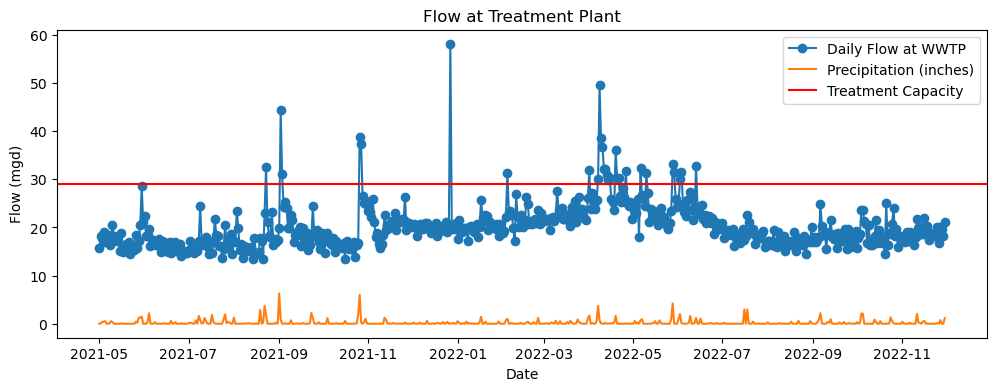

In [18]:
# Plotting the wwtp flow records
plt.figure(figsize=(12, 4))
plt.plot(df_flow['wwtp_flow'], label = "Daily Flow at WWTP", marker='o')
plt.plot(df_flow['precip_daily'], label = "Precipitation (inches)")
plt.axhline(y=29, color = 'Red', label = "Treatment Capacity")
plt.legend()
plt.xlabel('Date')
plt.ylabel('Flow (mgd)')
plt.title('Flow at Treatment Plant')
plt.show()

### Graph of flow to the treatment plant versus precipitation


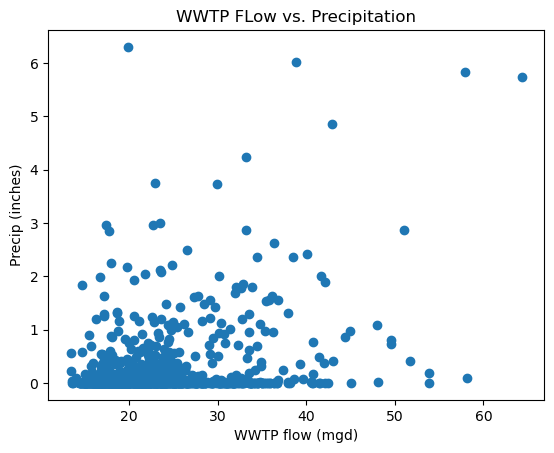

In [19]:
# Plot of wwtp_flow vs precipitation
plt.scatter(df_full['wwtp_flow'], df_full['precip_daily'])
plt.xlabel('WWTP flow (mgd)')
plt.ylabel('Precip (inches)')
plt.title('WWTP FLow vs. Precipitation')
plt.show()

### Graph of flow to the treatment plant versus flow in river

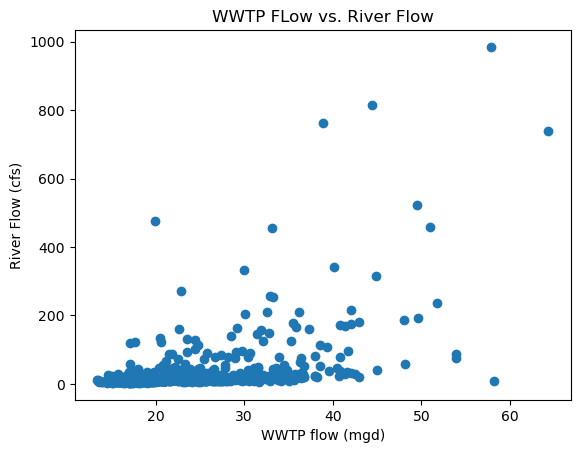

In [20]:
# Plot of wwtp_flow vs river flow
plt.scatter(df_full['wwtp_flow'], df_full['river_flow'])
plt.xlabel('WWTP flow (mgd)')
plt.ylabel('River Flow (cfs)')
plt.title('WWTP FLow vs. River Flow')
plt.show()

### Graph of flow to the treatment plant versus previous day flow

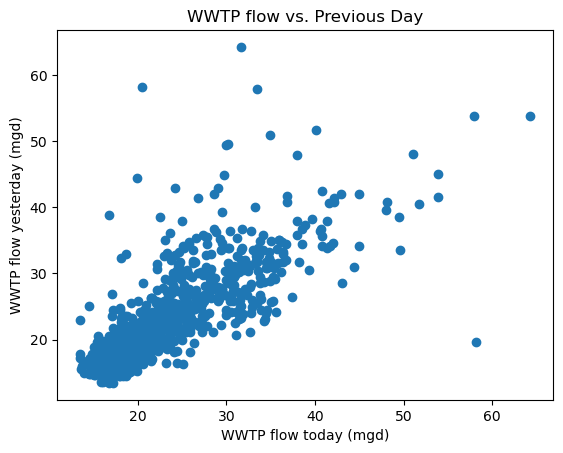

In [21]:
# Plot of treament plant flow today vs previous day
df_full['flow_prev']=df_full['wwtp_flow'].shift(-1)
plt.scatter(df_full['wwtp_flow'], df_full['flow_prev'])
plt.xlabel('WWTP flow today (mgd)')
plt.ylabel('WWTP flow yesterday (mgd)')
plt.title('WWTP flow vs. Previous Day')
plt.show()

### Reviewing correlations of features
 - treatmnet plant flow and river flow are correlated
 - the morning precip (preicp_am) has higher correlation with the daily flows (time of response effect)

<Axes: >

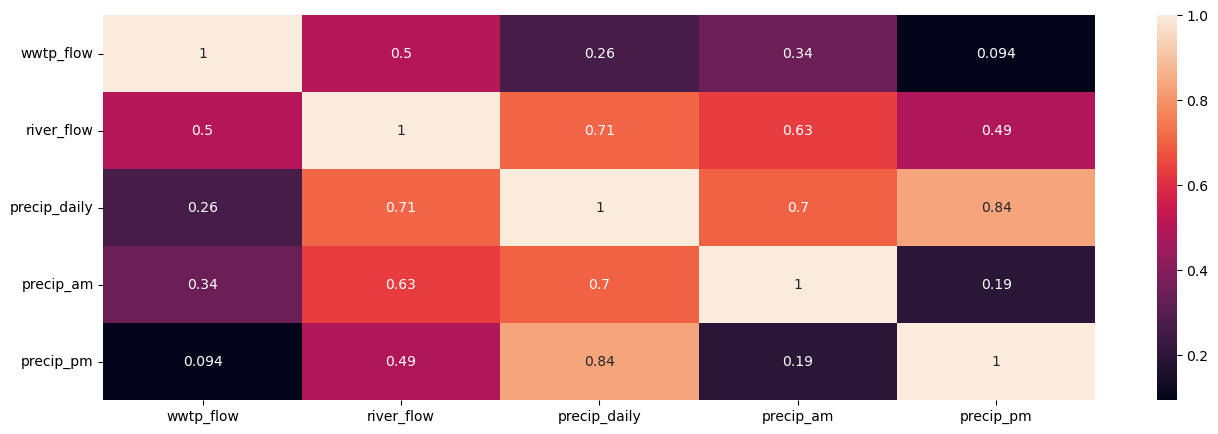

In [22]:
# Correlation plot
df_corr = df_flow.corr()
plt.figure(figsize = (16,5))
sns.heatmap(data  = df_corr, annot = True)